# Shifts and Lags

In [ ]:
# libraries

library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


library(brms)
library(loo)
library(haven)
library(ggridges)
library(sdazar)

library(MASS)
library(stringr)

library(ggplot2)
library(patchwork)

options(repr.plot.width = 5, repr.plot.height = 3)

source('Rutils/functions.R') # functions

In [2]:
# load data
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

In [3]:
country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

In [4]:
df[, ctry := factor(ctry, labels=country_labels)]

# Average Male - Female

In [9]:
dt = df[tseries2==1 & age==0 & year>=1900, # average life expectancies
           .(
               Ex=mean(Ex), 
               gdp_pc=max(gdp_pc)
            ), 
           by=.(ctry, year)]

In [10]:
dt = dt[complete.cases(dt[, .(Ex, gdp_pc)])] # listwise

In [11]:
dt = dt[, .(ctry, year, gdp_pc, Ex)]
setnames(dt, c('gdp_pc', 'Ex'), c('gdp', 'le'))

In [12]:
dt[, le_log := scale(log(le), scale=FALSE)]
dt[, gdp_log := scale(log(gdp), scale=FALSE)]
dt[, year_log := scale(log(year), scale=FALSE)]

In [13]:
# year recode based on the criteria proposed by Alberto
dt[year<1950, gyear:=1]
dt[year>=1950 & year<1970, gyear:=2]
dt[year>=1970 & year<1990, gyear:=3]
dt[year>=1990, gyear :=4]
dt[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

In [14]:
# transform variable: weibull
dt[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
dt[, wy := log(-log(1-y))]

In [15]:
max_le = dt[, .(max_le = max(le+1.05)), by = ctry]

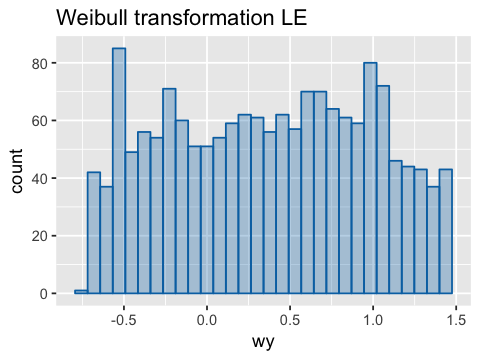

In [16]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(dt, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

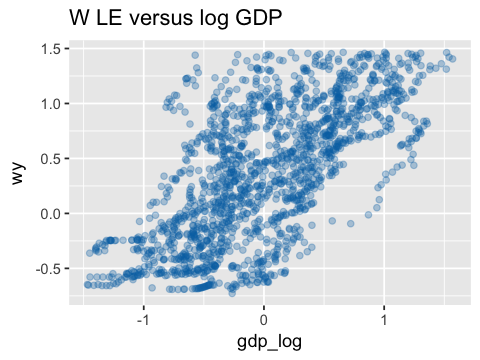

In [17]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(dt, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.3, color='#0072B2') +
    labs(title='W LE versus log GDP')

In [18]:
# create group variable for random effect
dt[, ctry_year := interaction(ctry, gyear)]

### Bayesian model 

In [19]:
m1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = dt)

Compiling the C++ model
Start sampling


In [21]:
summary(m1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: dt (Number of observations: 1657) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.55      0.05     0.46     0.66        537 1.00
sd(gdp_log)                0.70      0.07     0.58     0.84       1127 1.00
cor(Intercept,gdp_log)     0.09      0.13    -0.17     0.35        641 1.01

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.40      0.07     0.27     0.53        362 1.02
gdp_log       0.75      0.08     0.59     0.91        601 1.01

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.00   

### Examine GOF

In [27]:
get_orig_values_weibull = function(x, max_value) { 
    return ( (1 - exp(-exp(x))) * max_value )
}

In [24]:
pred = cbind(dt[, .(ctry, year, le, gdp_log, le_log)], predict(m1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [25]:
pred = merge(pred, max_le, by = 'ctry')

In [28]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_le), 
    lo = get_orig_values_weibull(lo, max_le),
    hi = get_orig_values_weibull(hi, max_le)
    )]

In [29]:
max_ex = max(dt$le)+25.0
min_ex = min(dt$le)-25.0
max_year = max(dt$year)
min_year = min(dt$year)

plots = list()
for (c in country_labels) {

assign(paste0('plot', which(country_labels == c)), ggplot(pred[ctry==c], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=0.3, color='#e34a33', alpha=0.4) +
    labs(title=c) + 
        ylim(min_ex, max_ex) + 
        xlim(min_year, max_year) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted')
       )
    
    }

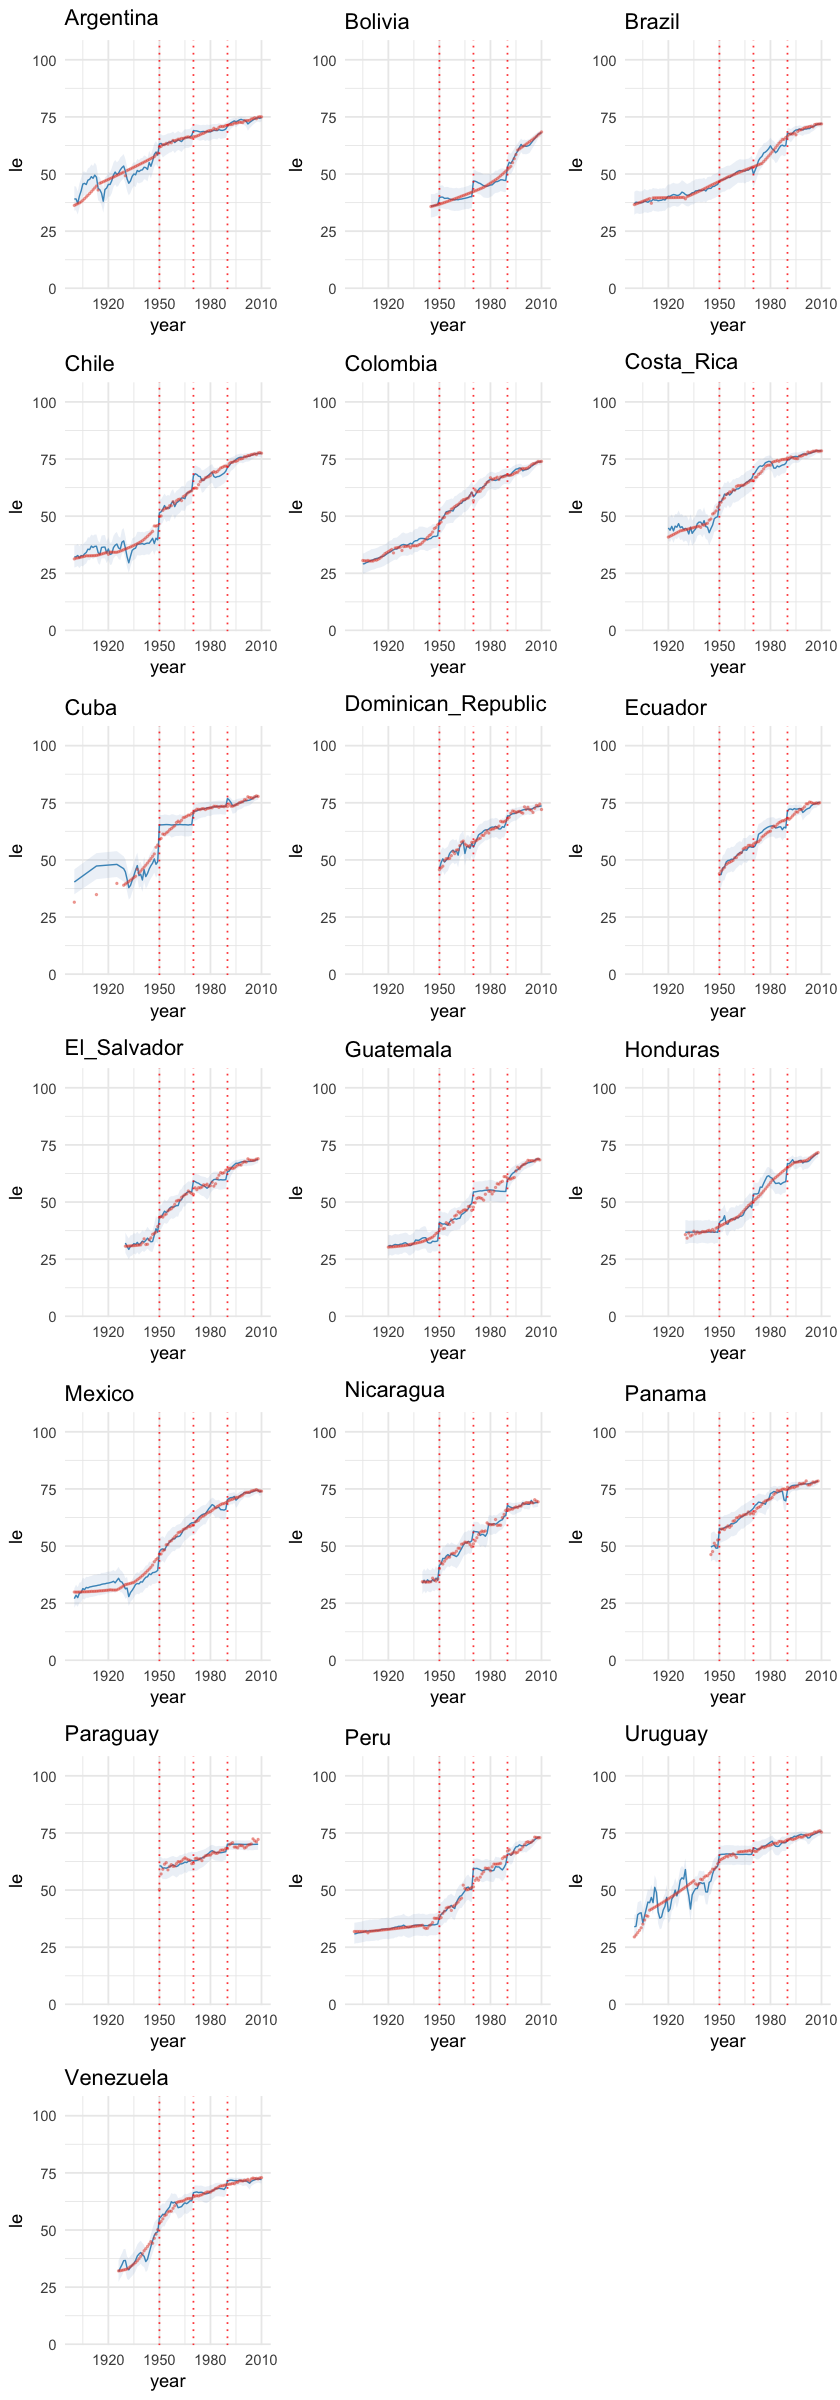

In [30]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(country_labels), collapse='+'), 
                       '+ plot_layout(ncol = 3)')))

In [31]:
# export predictions
fwrite(pred[, .(ctry, year, le, m, lo, hi)], '../dash/data/pred.csv')

# Compute shifts

- Each counterfactual LE for given year t is based on a year segment j (e.g., 1950-1969). That is, the intercept and slope of period j and GDP value of year t
- Predicted LE values (non-counterfactual) correspond to the predicted LE values show in the first plot (prediction checks)
- Lines represent the difference between predicted LE values (non-counterfactual) and counterfactual values using always GDP of year t
- If year t = 1950, the red line (<1950) represents the difference between predicted LE values for 1950 and (counterfactual) LE values if both intercept and slope would remain as before 1950 but with the GDP levels of 1950

In [32]:
# functions 

estimate_shift = function(samples,
                          gdp_value=NULL,
                          le_value=NULL,
                          country=NULL, 
                          model_year=NULL,
                          year=NULL,
                          max_le = NULL,
                          coefficients = c('Intercept', 'gdp_log')) {
    
    colnames = names(samples)
                          
    betas = paste0('b_', coefficients)
    
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))
    s = samples[, c(betas, random)]  
    
    pred = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_value
    pred = unlist(sapply(pred, function(x) get_orig_values_weibull(x, max_value=max_le)))
    
    return(le_value-pred)           
}

In [33]:
test_shifts = estimate_shift(samples=posterior_samples(m1), 
               country='Argentina',
               le_value=dt[ctry=='Argentina' & year==1950,le],
               gdp_value=dt[ctry=='Argentina' & year==1950, gdp_log],
               year=1950, 
               model_year='1950',
               max_le=max_le[ctry=='Argentina', max_le])

In [34]:
# function to go through years and countries

compute_shifts = function(model, 
                          data, 
                          country_labels,
                          iyears, 
                          max_le,
                          coefficients,
                          predicted_le=FALSE) {
        
    samples = posterior_samples(model)
    colnames = names(samples)

    model_pred = list('1950' = '1950-1969', '1970' = '1970-1989', '1990' = '1990', '2010'= '1990')
    
    shifts = list()

    for (c in country_labels) {
        
        years = as.numeric(data[ctry==c & year %in% iyears, year])
        segments = as.character(unique(data[ctry==c, gyear])) 
        max_le_value = max_le[ctry==c, max_le]
        
        for (ys in years) {
            
             fsegments = segments[-which(segments == model_pred[[as.character(ys)]])]
            
             if (predicted_le) {
                 
                 betas = paste0('b_', coefficients)
                 my = model_pred[[as.character(ys)]]
     
                 random = str_subset(colnames, paste0('^r_.+\\[', c, '.', my, ','))
                 s = samples[, c(betas, random)]
    
                 gdp_log = data[ctry==c & year==ys, gdp_log]
                 
                 le_value = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_log[1]
                 
                 le_value = unlist(sapply(le_value, function(x) 
                     get_orig_values_weibull(x, max_value=max_le_value)))
            } 
            else {
                le_value = data[ctry==c & year==ys, le][1]
            }
                                          
            for (ysm in fsegments) {
               
               est = estimate_shift(samples=samples, 
                   le_value=le_value, 
                   gdp_value = data[ctry==c & year==ys, gdp_log],
                   country=c, 
                   year=ys, 
                   model_year=ysm,
                   max_le=max_le_value, 
                   coefficients=coefficients)
            
            name = paste0(c(c,ys,ysm), collapse='.')
            shifts[[paste0(c(c,ys,ysm), collapse='.')]] = data.table(name, pred_shift = est)
                
            }
        }   
        
     }
       shifts = rbindlist(shifts)
       shifts[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)]

        return(shifts)
}

In [35]:
iyears = c(1950, 1970, 1990, 2010)

In [36]:
shift_obs = compute_shifts(model=m1, 
                             data=dt, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=FALSE)

shift_pred = compute_shifts(model=m1, 
                             data=dt, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=TRUE)

In [37]:
# export shifts
fwrite(shift_pred[,.(ctry, year, segment, pred_shift)], '../dash/data/shifts_pred.csv')
fwrite(shift_obs[,.(ctry, year, segment, pred_shift)], '../dash/data/shifts_obs.csv')

# Lags

- Either using observed or predicted LE values (prediction checks plot), we get two vectors (LE values, years)
- We use the mean of predicted values (blue line in the first plot)
- We compute a counterfactual for year t using the intercept and slope of period j and GDP values of year t
- Values represent the difference between year t and the year with the smallest difference between observed/predicted LE values (average) and counterfactual LE values

In [38]:
# functions

estimate_lags = function(samples, 
                         country=NULL, 
                         model_year=NULL,
                         le_values=NULL,
                         year_values=NULL,
                         year=NULL,
                         gdp_value = NULL, 
                         max_le_value = NULL,
                         coefficients = c('Intercept', 'gdp_log')) {
    
    colnames = names(samples)
    betas = paste0('b_', coefficients)
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))

    s = samples[, c(betas, random)]

    pred = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_value
    pred = unlist(sapply(pred, function(x) 
            get_orig_values_weibull(x, max_value=max_le_value)))
     
    ind = NULL
    for (i in 1:length(pred)) {
        ind[i] = which.min(abs(le_values - pred[i]))
        }
           
    return(year_values[ind]-year)
}

In [39]:
test_lags = estimate_lags(samples=posterior_samples(m1), 
             country='Argentina', 
             model_year='1950', 
             le_values=dt[ctry=='Argentina', le], 
             year_values=dt[ctry=='Argentina', year],
             year=1950, 
             gdp_value=dt[ctry=='Argentina' & year==1950, gdp_log], 
             max_le_value=max_le[ctry=='Argentina', max_le])  

In [43]:
compute_lags = function(model,
                        data, 
                        country_labels, 
                        iyears,
                        max_le, 
                        predicted_le=FALSE, 
                        coefficients) {

    model_years = list('1950' = '1950-1969', '1970' = '1970-1989', '1990' = '1990', '2010' = '1990')
    samples = posterior_samples(model)
    
    lags = list()

    for (c in country_labels) {
    
    max_le_value = max_le[ctry==c, max_le]
    iyears = as.numeric(data[ctry==c & year %in% iyears, year])
    segments = as.character(unique(data[ctry==c, gyear]))
        
      if (predicted_le) {
          le_values = predict(model, data[ctry==c], summary=FALSE)
          le_values = apply(le_values, 2, mean)
          
          le_values = unlist(lapply(le_values,  function(x) 
              get_orig_values_weibull(x, max_le_value)))
          year_values = data[ctry==c, year]
        } 
        else { 
            le_values = data[ctry==c, le]
            year_values = data[ctry==c, year]       
        }
    
    for (ys in iyears) {
        
            fsegments = segments[-which(segments == model_years[[as.character(ys)]])]
            gdp_value= data[ctry==c & year==ys, gdp_log]
        
        for (ysm in fsegments) { 
         
            est = estimate_lags(samples=samples, 
                         country=c, 
                         model_year=ysm,
                         year=ys,
                         le_values=le_values,
                         year_values=year_values,
                         gdp_value=gdp_value, 
                         max_le_value=max_le_value,
                     )

                name = paste0(c(c,ys,ysm), collapse='.')
                lags[[paste0(c(c,ys,ysm), collapse='.')]] = data.table(name, pred_lag = est)

                  }
            }
    }
       lags = rbindlist(lags)
       lags[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)]

       return(lags)
}

In [46]:
lags_obs = compute_lags(model=m1, 
                        data=dt, 
                        country_labels=country_labels, 
                        iyears=iyears,
                        max_le=max_le, 
                        predicted_le=FALSE)

In [47]:
lags_pred = compute_lags(model=m1, 
                        data=dt, 
                        country_labels=country_labels, 
                        iyears=iyears,
                        max_le=max_le, 
                        predicted_le=TRUE)

In [48]:
# export lags
fwrite(lags_pred[,.(ctry, year, segment, pred_lag)], '../dash/data/lags_pred.csv')
fwrite(lags_obs[,.(ctry, year, segment, pred_lag)], '../dash/data/lags_obs.csv')